# **Drinking Waste Classification**

## ***Import***

In [2]:

import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
import matplotlib.pyplot as plt
from keras.preprocessing import image
import keras.backend as K
import random
import optuna


## ***Load data***

In [3]:
data_path = 'drive\dataset_70_15_15.npz'
data = np.load(data_path)
print(*[d for d in data])
x_train = data["x_train"]
y_train = data["y_train"]
x_validation = data["x_validation"]
y_validation = data["y_validation"]
x_test = data["x_test"]
y_test = data["y_test"]
train_size = len(x_train)
validation_size = len(x_validation)
test_size = len(x_test)
print(f"Train size : {train_size}")
print(f"Validation size : {validation_size}")
print(f"Test size : {test_size}")

x_train y_train x_validation y_validation x_test y_test
Train size : 7490
Validation size : 1605
Test size : 1604


## ***Convolutional base***

In [3]:
# Instantiate convolutional base
img_width, img_height = 224, 224
batch_size = 256
n_class = 3
conv_base = InceptionV3(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3),
                  pooling="avg"
                  )  # 3 = number of channels in RGB pictures
conv_base.trainable = False

## ***Data preprocessing***

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_class)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=True
)

y_validation = tf.keras.utils.to_categorical(y_validation, num_classes=n_class)
validation_generator = val_datagen.flow(
    x_validation,
    y_validation,
    batch_size=batch_size,
    shuffle=True
)

## ***Classifier***

In [ ]:
epochs = 100

model = models.Sequential()
model.add(conv_base)

model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu', input_dim=5 * 5 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_class, activation='softmax'))
# Compile model
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=validation_generator,
                    verbose=True)

Epoch 1/100


30/30 [==============================] - 695s 22s/step - loss: 1.0960 - acc: 0.6698 - val_loss: 0.4536 - val_acc: 0.8455
Epoch 2/100
30/30 [==============================] - 695s 23s/step - loss: 0.4269 - acc: 0.8263 - val_loss: 0.2945 - val_acc: 0.8972
Epoch 3/100
30/30 [==============================] - 690s 23s/step - loss: 0.3400 - acc: 0.8638 - val_loss: 0.2435 - val_acc: 0.9134
Epoch 4/100
30/30 [==============================] - 716s 24s/step - loss: 0.3123 - acc: 0.8761 - val_loss: 0.2635 - val_acc: 0.9022
Epoch 5/100
30/30 [==============================] - 716s 24s/step - loss: 0.2888 - acc: 0.8842 - val_loss: 0.2108 - val_acc: 0.9252
Epoch 6/100
30/30 [==============================] - 654s 22s/step - loss: 0.2664 - acc: 0.8979 - val_loss: 0.2033 - val_acc: 0.9308
Epoch 7/100
30/30 [==============================] - 608s 20s/step - loss: 0.2609 - acc: 0.8987 - val_loss: 0.1851 - val_acc: 0.9402
Epoch 8/100
30/30 [==============================] - 618s 21s/step 

## **Model summary**

In [ ]:
print(f"Model learning rate : {K.eval(model.optimizer.lr):.3f}")

Model learning rate : 0.001


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 


Total params: 23904035 (91.19 MB)
Trainable params: 2101251 (8.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


## **Model save**


In [ ]:
model.save(f"model_70_15_15_b256_v9.h5")

c:\Users\Teba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## ***Accuracy & Loss***

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


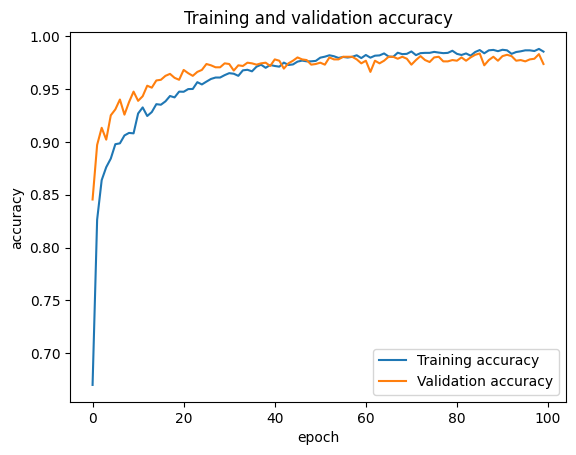

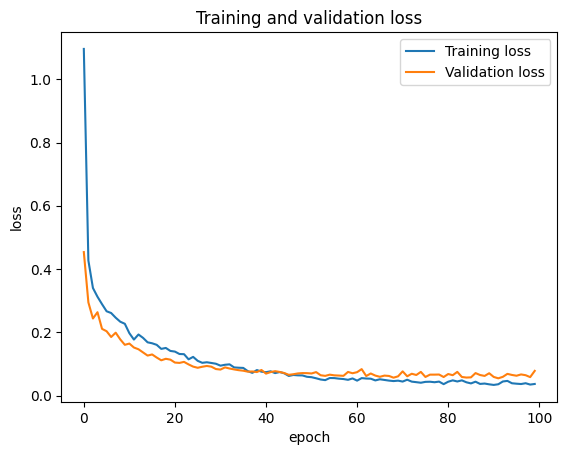

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')
plt.show()

## ***Test data***

In [ ]:
def predict(classifier, x_data, y_data):
  # Normalize to [0,1] for plt.imshow application
  x_data = np.true_divide(x_data, 255) 
  # Extract features
  #features = conv_base.predict(x_data.reshape(1,img_width, img_height, 3))
  # Make prediction
  prediction = classifier.predict(x_data.reshape(1,224,224,3))
  label = ["AluCan", "Glass", "PET"]
  result = label[np.argmax(prediction)]
  real = label[y_data]
  # Show picture
  plt.imshow(x_data)
  plt.show()
  # Write prediction
  print(prediction)
  print(f"AluCan : {prediction[0][0] * 100}% Glass : {prediction[0][1] * 100}% PET : {prediction[0][2] * 100}%")
  print(f"Real : {real}")
  print(f"Predict : {result}")

1/1 [==============================] - 7s 7s/step


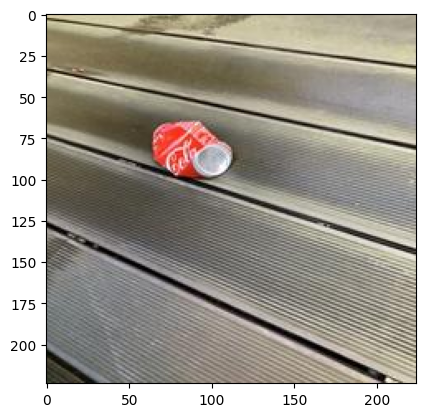

[[9.9999940e-01 6.0712051e-07 1.4118613e-08]]
AluCan : 99.99994039535522% Glass : 6.071205120861123e-05% PET : 1.4118612945424047e-06%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 224ms/step


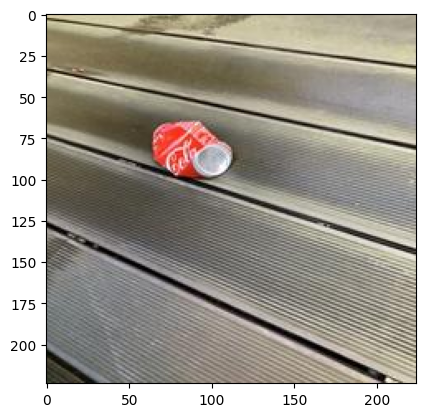

[[9.9999940e-01 6.0712051e-07 1.4118613e-08]]
AluCan : 99.99994039535522% Glass : 6.071205120861123e-05% PET : 1.4118612945424047e-06%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 158ms/step


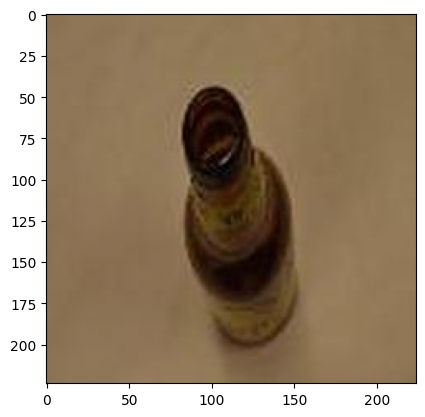

[[8.3618154e-08 9.9999952e-01 3.5676487e-07]]
AluCan : 8.361815417856633e-06% Glass : 99.99995231628418% PET : 3.5676487186719896e-05%
Real : Glass
Predict : Glass
1/1 [==============================] - 0s 199ms/step


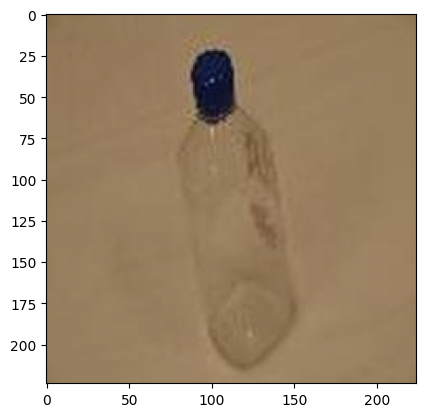

[[8.2631418e-14 6.7876664e-07 9.9999928e-01]]
AluCan : 8.263141825512813e-12% Glass : 6.78766639339301e-05% PET : 99.99992847442627%
Real : PET
Predict : PET
1/1 [==============================] - 0s 234ms/step


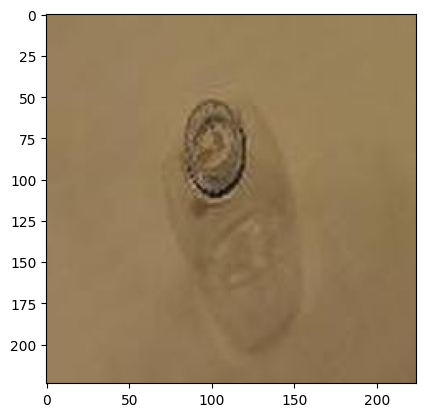

[[8.2014943e-05 2.2385681e-02 9.7753227e-01]]
AluCan : 0.008201494347304106% Glass : 2.238568104803562% PET : 97.75322675704956%
Real : PET
Predict : PET
1/1 [==============================] - 0s 198ms/step


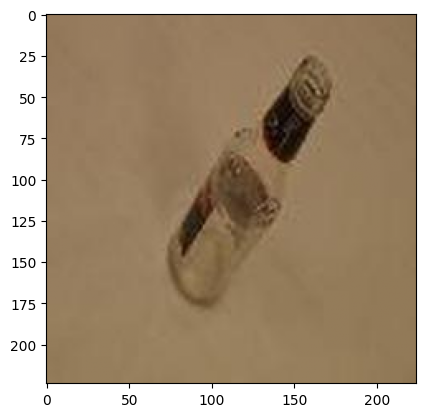

[[5.7498337e-06 9.8490566e-01 1.5088562e-02]]
AluCan : 0.0005749833690060768% Glass : 98.49056601524353% PET : 1.5088561922311783%
Real : Glass
Predict : Glass
1/1 [==============================] - 0s 207ms/step


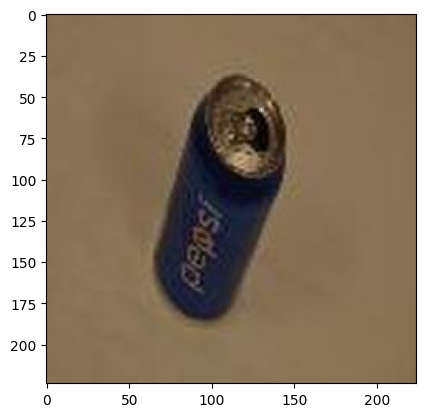

[[1.0000000e+00 3.6870265e-09 6.3201011e-14]]
AluCan : 100.0% Glass : 3.687026461918208e-07% PET : 6.320101099367356e-12%
Real : AluCan
Predict : AluCan
1/1 [==============================] - 0s 160ms/step


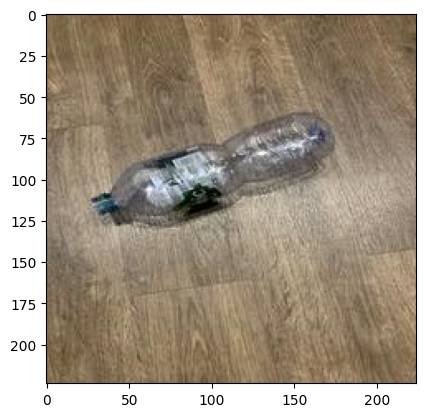

[[7.2654548e-05 2.8831263e-03 9.9704427e-01]]
AluCan : 0.007265454769367352% Glass : 0.2883126260712743% PET : 99.70442652702332%
Real : PET
Predict : PET
1/1 [==============================] - 0s 185ms/step


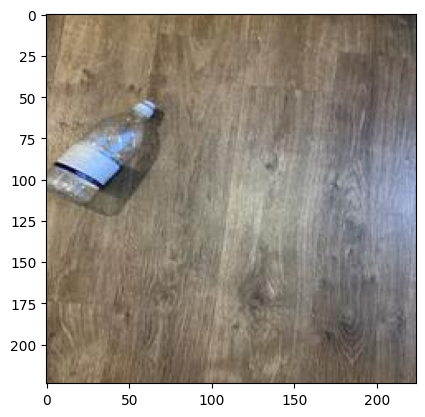

[[1.4246241e-06 1.0910155e-02 9.8908842e-01]]
AluCan : 0.00014246240880311234% Glass : 1.09101552516222% PET : 98.90884160995483%
Real : PET
Predict : PET
1/1 [==============================] - 0s 146ms/step


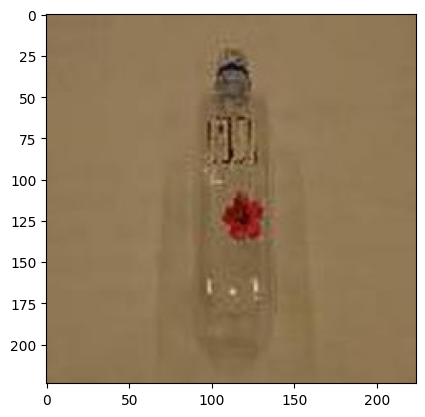

[[6.4284286e-05 4.4586718e-01 5.5406857e-01]]
AluCan : 0.006428428605431691% Glass : 44.58671808242798% PET : 55.406856536865234%
Real : PET
Predict : PET


In [ ]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
  for i in range(n_cases):
    test_set = [*zip(x_test, y_test)]
    x_to_test, y_to_test = random.choice(test_set)
    predict(classifier, x_to_test, y_to_test)

# Visualize predictions
visualize_predictions(model, 10)

In [ ]:
predict_x = model.predict(np.true_divide(x_test, 255)) 
predictions = np.argmax(predict_x, axis=1)
errors = np.where(predictions != y_test)[0]
print(f"index of error : \n{errors}")
print("\nNo of errors = {}/{}".format(len(errors),test_size))

51/51 [==============================] - 119s 2s/step
index of error : 
[  46  331  384  436  446  483  512  519  552  564  635  655  668  673
  679  685  688  704  723  789  808  812  818  847  984 1038 1108 1112
 1130 1149 1157 1206 1211 1243 1320 1337 1346 1378 1575]

No of errors = 39/1604


In [ ]:
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=n_class)
score = model.evaluate(np.true_divide(x_test, 255), y_test_categorical)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

51/51 [==============================] - 108s 2s/step - loss: 0.0617 - acc: 0.9757
acc: 97.57%


### ***Error images***

1/1 [==============================] - 0s 194ms/step


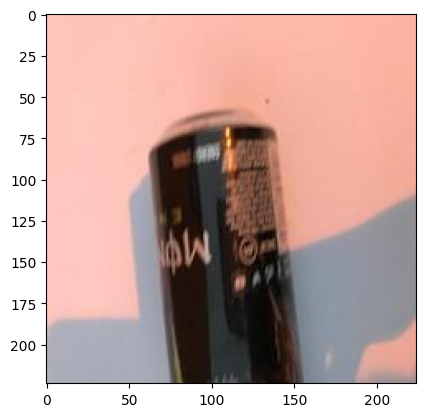

[[3.4109792e-01 6.5890211e-01 1.2995659e-08]]
AluCan : 34.10979211330414% Glass : 65.8902108669281% PET : 1.299565877133091e-06%
Real : AluCan
Predict : Glass
1/1 [==============================] - 0s 196ms/step


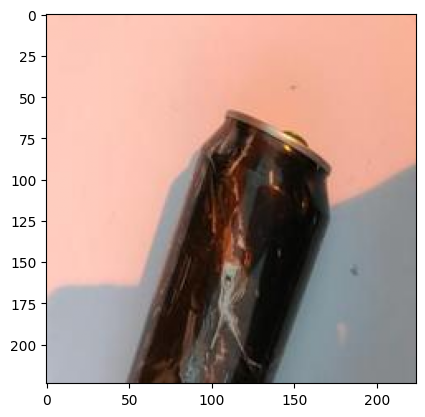

[[1.4427690e-02 9.8555601e-01 1.6305892e-05]]
AluCan : 1.4427689835429192% Glass : 98.55560064315796% PET : 0.0016305892131640576%
Real : AluCan
Predict : Glass
1/1 [==============================] - 0s 165ms/step


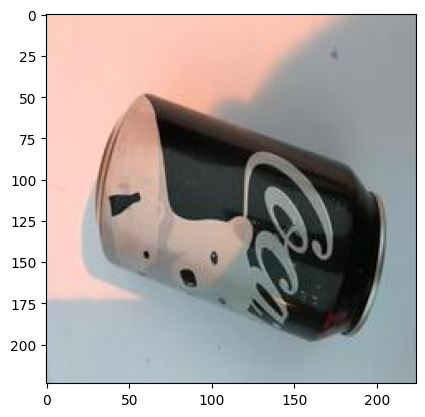

[[0.29821074 0.6870663  0.01472289]]
AluCan : 29.82107400894165% Glass : 68.70663166046143% PET : 1.4722894877195358%
Real : AluCan
Predict : Glass
1/1 [==============================] - 0s 176ms/step


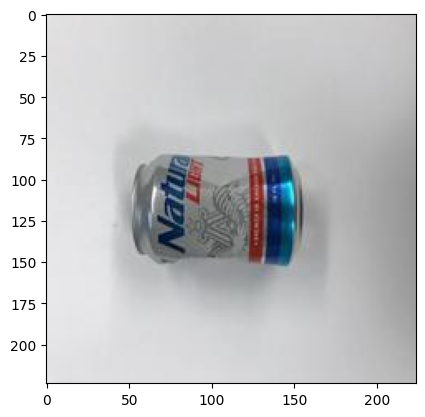

[[0.08749637 0.87252855 0.03997506]]
AluCan : 8.749637007713318% Glass : 87.25285530090332% PET : 3.9975062012672424%
Real : AluCan
Predict : Glass
1/1 [==============================] - 0s 211ms/step


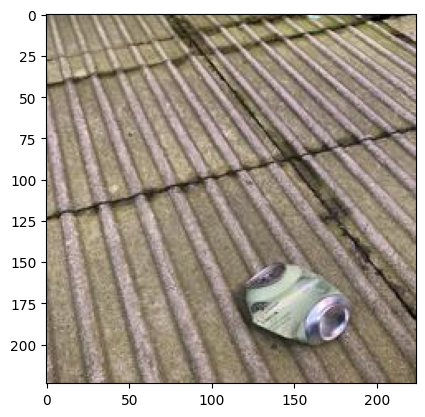

[[9.1989800e-02 8.6590572e-04 9.0714437e-01]]
AluCan : 9.198980033397675% Glass : 0.08659057202748954% PET : 90.71443676948547%
Real : AluCan
Predict : PET
1/1 [==============================] - 0s 178ms/step


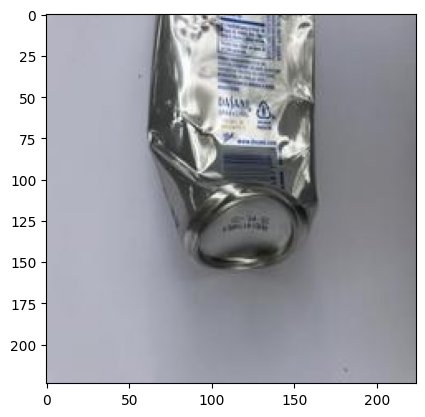

[[0.04117142 0.9499606  0.00886802]]
AluCan : 4.117142036557198% Glass : 94.99605894088745% PET : 0.8868016302585602%
Real : AluCan
Predict : Glass
1/1 [==============================] - 0s 157ms/step


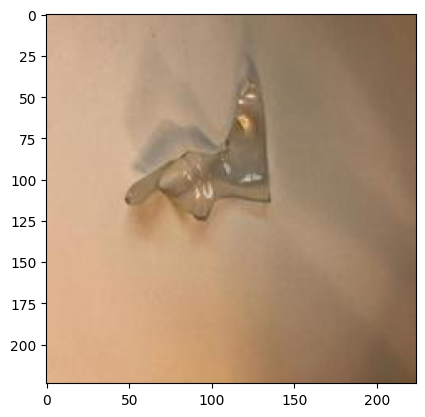

[[0.00881273 0.46032414 0.5308632 ]]
AluCan : 0.881272554397583% Glass : 46.032413840293884% PET : 53.08632254600525%
Real : Glass
Predict : PET
1/1 [==============================] - 0s 158ms/step


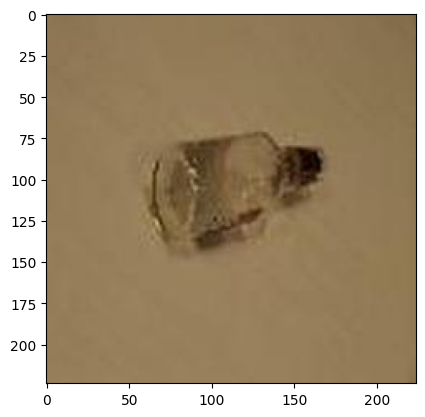

[[0.0859127 0.2387426 0.6753447]]
AluCan : 8.591269701719284% Glass : 23.87426048517227% PET : 67.5344705581665%
Real : Glass
Predict : PET
1/1 [==============================] - 0s 179ms/step


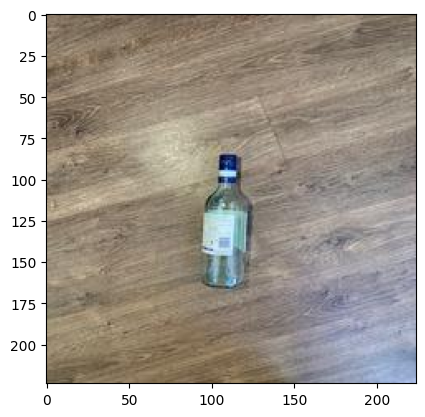

[[3.8867614e-11 1.9136101e-03 9.9808645e-01]]
AluCan : 3.886761398841365e-09% Glass : 0.19136101473122835% PET : 99.80864524841309%
Real : Glass
Predict : PET
1/1 [==============================] - 0s 189ms/step


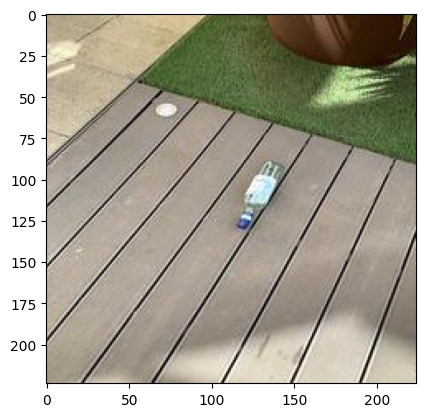

[[0.8727416  0.1198009  0.00745748]]
AluCan : 87.27415800094604% Glass : 11.980090290307999% PET : 0.7457481697201729%
Real : Glass
Predict : AluCan


In [ ]:
start_index = 0
end_index = 600
reverse = False
errors_list = errors[::-1] if reverse else errors
for index in errors_list:
  if start_index <= index <= end_index:
    x, y = x_test[index], y_test[index]
    predict(model, x, y)

In [1]:
import numpy as np
from tensorflow.keras.applications import InceptionV3, VGG19, DenseNet121
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ==============================================
# 1. LOAD DATA (HALF OF THE SAMPLES)
# ==============================================
def load_data_safely(data_path):
    data = np.load(data_path)
    try:
        # Load only half of the samples
        x_train = data["x_train"][:len(data["x_train"])//2]
        y_train = data["y_train"][:len(data["y_train"])//2]
        x_validation = data["x_validation"][:len(data["x_validation"])//2]
        y_validation = data["y_validation"][:len(data["y_validation"])//2]
        x_test = data["x_test"]  # Keep test set as is for final evaluation
        y_test = data["y_test"]
    finally:
        data.close()
    return x_train, y_train, x_validation, y_validation, x_test, y_test

try:
    data_path = 'drive/dataset_70_15_15.npz'
    x_train, y_train, x_validation, y_validation, x_test, y_test = load_data_safely(data_path)
except MemoryError:
    print("Not enough memory to load half dataset. Trying smaller subset...")
    # Fallback to even smaller subset if needed
    with np.load(data_path) as data:
        x_train = data["x_train"][:1000]
        y_train = data["y_train"][:1000]
        x_validation = data["x_validation"][:200]
        y_validation = data["y_validation"][:200]
        x_test = data["x_test"][:200]
        y_test = data["y_test"][:200]

print(f"\nDataset sizes:")
print(f"Training: {len(x_train)} samples")
print(f"Validation: {len(x_validation)} samples")
print(f"Test: {len(x_test)} samples")

# Convert labels to one-hot encoding if needed
if len(y_train.shape) == 1:
    # Get the maximum class label from all datasets to determine num_classes
    max_class = max(np.max(y_train), np.max(y_validation), np.max(y_test))
    num_classes = max_class + 1  # Assuming classes are 0-indexed
    print(f"\nConverting labels to one-hot encoding with {num_classes} classes")
    y_train = np.eye(num_classes)[y_train]
    y_validation = np.eye(num_classes)[y_validation]
    y_test = np.eye(num_classes)[y_test]

# ==============================================
# 2. DATA GENERATORS
# ==============================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# ==============================================
# 3. OPTUNA OPTIMIZATION FUNCTION (5 TRIALS)
# ==============================================
def objective(trial):
    # Model selection (InceptionV3, VGG19, or DenseNet121)
    model_name = trial.suggest_categorical('model', ['InceptionV3', 'VGG19', 'DenseNet121'])
    
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    dense_units = trial.suggest_int('dense_units', 512, 1024)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])

    # Build the selected model
    if model_name == 'InceptionV3':
        conv_base = InceptionV3(
            weights='imagenet',
            include_top=False,
            input_shape=x_train.shape[1:],
            pooling='avg'
        )
    elif model_name == 'VGG19':
        conv_base = VGG19(
            weights='imagenet',
            include_top=False,
            input_shape=x_train.shape[1:],
            pooling='avg'
        )
    else:  # DenseNet121
        conv_base = DenseNet121(
            weights='imagenet',
            include_top=False,
            input_shape=x_train.shape[1:],
            pooling='avg'
        )
    
    conv_base.trainable = False

    model = models.Sequential([
        conv_base,
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train with fewer epochs for optimization
    history = model.fit(
        train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
        validation_data=validation_datagen.flow(x_validation, y_validation, batch_size=batch_size),
        epochs=5,  # Reduced epochs for optimization
        verbose=0
    )

    return max(history.history['val_accuracy'])

# ==============================================
# 4. RUN OPTIMIZATION (5 TRIALS)
# ==============================================
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)  # Only 5 trials

# ==============================================
# 5. RESULTS AND SAVE BEST MODEL
# ==============================================
print('\nBest trial:')
best_trial = study.best_trial
print(f'  Validation Accuracy: {best_trial.value:.4f}')
print('  Best hyperparameters:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Retrain with best hyperparameters (full epochs)
if best_trial.params['model'] == 'InceptionV3':
    conv_base = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=x_train.shape[1:],
        pooling='avg'
    )
elif best_trial.params['model'] == 'VGG19':
    conv_base = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=x_train.shape[1:],
        pooling='avg'
    )
else:  # DenseNet121
    conv_base = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=x_train.shape[1:],
        pooling='avg'
    )

conv_base.trainable = False

best_model = models.Sequential([
    conv_base,
    layers.Dropout(best_trial.params['dropout_rate']),
    layers.Dense(best_trial.params['dense_units'], activation='relu'),
    layers.Dropout(best_trial.params['dropout_rate']),
    layers.Dense(num_classes, activation='softmax')
])

best_model.compile(
    optimizer=optimizers.Adam(learning_rate=best_trial.params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train final model with more epochs
history = best_model.fit(
    train_datagen.flow(x_train, y_train, batch_size=best_trial.params['batch_size']),
    validation_data=validation_datagen.flow(x_validation, y_validation),
    epochs=20,  # Increased epochs for final training
    verbose=1
)

# Save the best model
model_name = best_trial.params['model']
best_model.save(f'best_{model_name.lower()}_model.h5')
print(f"Best model saved as 'best_{model_name.lower()}_model.h5'")
# ==============================================
# 6. EVALUATION METRICS (F1, RECALL, PRECISION)
# ==============================================
# Generate predictions for all sets
x_train_normalized = x_train / 255.0
x_validation_normalized = x_validation / 255.0
x_test_normalized = x_test / 255.0

# Get predictions for all sets
y_train_pred = best_model.predict(x_train_normalized)
y_val_pred = best_model.predict(x_validation_normalized)
y_test_pred = best_model.predict(x_test_normalized)

# Convert to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Convert true labels to class indices
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_validation, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate metrics for each set
def calculate_metrics(y_true, y_pred, set_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print(f"\n{set_name} Set Classification Report:")
    print(classification_report(y_true, y_pred))

print("\n" + "="*60)
print(f"EVALUATION FOR BEST MODEL: {model_name}")
print("="*60)
# Calculate for all sets
calculate_metrics(y_train_classes, y_train_pred_classes, "Training")
calculate_metrics(y_val_classes, y_val_pred_classes, "Validation")
calculate_metrics(y_test_classes, y_test_pred_classes, "Test")

# ==============================================
# 7. COMPARATIVE EVALUATION OF ALL ARCHITECTURES
# ==============================================
def evaluate_architecture(model_class, model_name):
    print("\n" + "="*60)
    print(f"EVALUATING {model_name} ARCHITECTURE")
    print("="*60)
    
    # Create base model
    conv_base = model_class(
        weights='imagenet',
        include_top=False,
        input_shape=x_train.shape[1:],
        pooling='avg'
    )
    conv_base.trainable = False
    
    # Create model with standardized architecture for fair comparison
    model = models.Sequential([
        conv_base,
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train briefly (5 epochs)
    print(f"\nTraining {model_name} for comparison...")
    history = model.fit(
        train_datagen.flow(x_train, y_train, batch_size=32),
        validation_data=validation_datagen.flow(x_validation, y_validation),
        epochs=5,
        verbose=1
    )
    
    # Evaluate on all datasets
    def evaluate_set(x, y, set_name):
        x_norm = x / 255.0
        y_pred = model.predict(x_norm)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y, axis=1)
        
        print(f"\n{model_name} - {set_name} Results:")
        print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.4f}")
        print(f"Precision: {precision_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")
        print(f"Recall: {recall_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")
        print(f"F1: {f1_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")
        print(classification_report(y_true_classes, y_pred_classes))
    
    evaluate_set(x_train, y_train, "Training")
    evaluate_set(x_validation, y_validation, "Validation")
    evaluate_set(x_test, y_test, "Test")
    
    return model

# Evaluate all architectures
architectures = [
    (InceptionV3, 'InceptionV3'),
    (DenseNet121, 'DenseNet121'), 
    (VGG19, 'VGG19')
]

comparison_models = {}
for model_class, name in architectures:
    model = evaluate_architecture(model_class, name)
    comparison_models[name] = model

# ==============================================
# 8. PLOT TRAINING HISTORY FOR BEST MODEL
# ==============================================
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Best Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

[I 2025-05-22 18:15:22,145] A new study created in memory with name: no-name-ed95bb83-85e3-416b-af1b-f04650b89f3d



Dataset sizes:
Training: 3745 samples
Validation: 802 samples
Test: 1604 samples

Converting labels to one-hot encoding with 3 classes






[I 2025-05-22 18:37:04,747] Trial 0 finished with value: 0.9526184797286987 and parameters: {'model': 'InceptionV3', 'learning_rate': 2.2494718260232753e-05, 'dropout_rate': 0.4340978601019062, 'dense_units': 538, 'batch_size': 16}. Best is trial 0 with value: 0.9526184797286987.
[I 2025-05-22 19:04:05,970] Trial 1 finished with value: 0.9850373864173889 and parameters: {'model': 'DenseNet121', 'learning_rate': 0.003469246443334911, 'dropout_rate': 0.31625364024173763, 'dense_units': 853, 'batch_size': 16}. Best is trial 1 with value: 0.9850373864173889.
[I 2025-05-22 21:07:54,896] Trial 2 finished with value: 0.8790523409843445 and parameters: {'model': 'VGG19', 'learning_rate': 0.000715261100212737, 'dropout_rate': 0.395428757127677, 'dense_units': 682, 'batch_size': 16}. Best is trial 1 with value: 0.9850373864173889.
[I 2025-05-22 21:27:50,074] Trial 3 finished with value: 0.9476309418678284 and parameters: {'model': 'InceptionV3', 'learning_rate': 0.004935563739620683, 'dropout_ra


Best trial:
  Validation Accuracy: 0.9850
  Best hyperparameters:
    model: DenseNet121
    learning_rate: 0.003469246443334911
    dropout_rate: 0.31625364024173763
    dense_units: 853
    batch_size: 16
Epoch 1/20
235/235 [==============================] - 337s 1s/step - loss: 0.4271 - accuracy: 0.8710 - val_loss: 0.1272 - val_accuracy: 0.9514
Epoch 2/20
235/235 [==============================] - 324s 1s/step - loss: 0.1830 - accuracy: 0.9298 - val_loss: 0.0803 - val_accuracy: 0.9738
Epoch 3/20
235/235 [==============================] - 326s 1s/step - loss: 0.1662 - accuracy: 0.9343 - val_loss: 0.0624 - val_accuracy: 0.9800
Epoch 4/20
235/235 [==============================] - 321s 1s/step - loss: 0.1359 - accuracy: 0.9474 - val_loss: 0.0507 - val_accuracy: 0.9863
Epoch 5/20
235/235 [==============================] - 323s 1s/step - loss: 0.1266 - accuracy: 0.9533 - val_loss: 0.0463 - val_accuracy: 0.9875
Epoch 6/20
235/235 [==============================] - 322s 1s/step - loss: 0.

c:\Users\Teba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Best model saved as 'best_densenet121_model.h5'


MemoryError: Unable to allocate 4.20 GiB for an array with shape (3745, 224, 224, 3) and data type float64